# Modern Deep Learning Practices [Hands On]

- We've just seen how a number of techniques came togeter in the late 2010s to create the practice of modern deep learning.
- Here, we'll bring these techniques together to build and train a modern deep learning classifier in PyTorch.

## 0. Imports and Such

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
from matplotlib.pyplot import *

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
#Check if we have a GPU:
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

## 1. Load Dataset 

In [5]:
#Let's experiment with Fashion MNIST
transform = transforms.Compose([transforms.ToTensor()])
data = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True, num_workers=2)

data_valid = torchvision.datasets.FashionMNIST('data', train=False, download=True, transform=transform)
valid_dl = torch.utils.data.DataLoader(data_valid, batch_size=16, shuffle=True, num_workers=2)

In [6]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

In [7]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

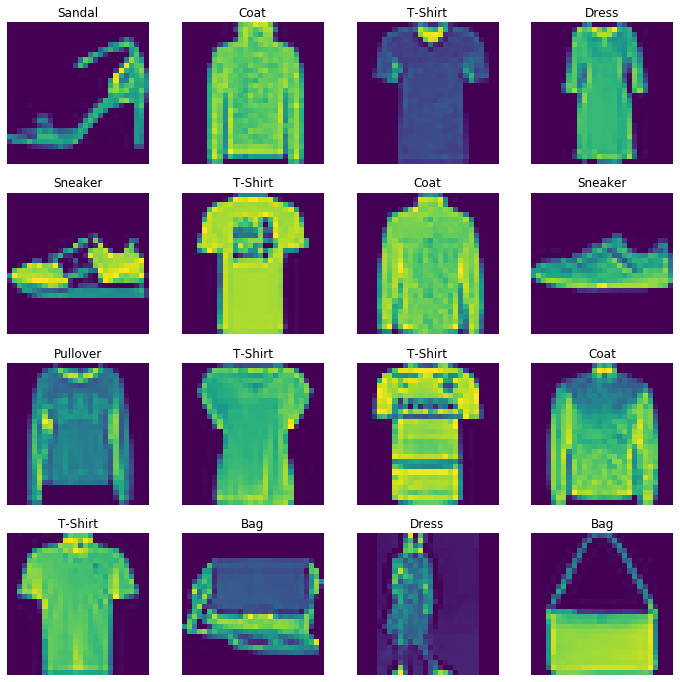

In [8]:
fig=figure(0, (12,12))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    imshow(x[i, 0, :, :]); title(labels_map[y[i].item()]); axis('off')

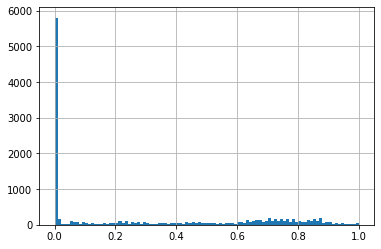

In [9]:
hist(x.numpy().ravel(), 100); grid(1)

## 2. LeNet-5 Baseline

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [11]:
#Borrow idea of Lambda Module from Jeremy Howard
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [12]:
# Modern Version of LeNet-5 in Pytorch
model = nn.Sequential(nn.Conv2d(1, 6, kernel_size = 5), nn.Tanh(), 
                     nn.AvgPool2d(2), 
                     nn.Conv2d(6, 16 , kernel_size = 5), nn.Tanh(), 
                     nn.AvgPool2d(2), 
                     Lambda(lambda x: x.view(x.size(0),-1)), 
                     nn.Linear(256, 120), nn.Tanh(),
                     nn.Linear(120, 84), nn.Tanh(),
                     nn.Linear(84, 10)).to(device)

In [13]:
x, y = next(iter(train_dl))
for i in range(1, len(model)):
    a = model[:i](x)
    print(model[i], a.shape)

Tanh() torch.Size([16, 6, 24, 24])
AvgPool2d(kernel_size=2, stride=2, padding=0) torch.Size([16, 6, 24, 24])
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) torch.Size([16, 6, 12, 12])
Tanh() torch.Size([16, 16, 8, 8])
AvgPool2d(kernel_size=2, stride=2, padding=0) torch.Size([16, 16, 8, 8])
Lambda() torch.Size([16, 16, 4, 4])
Linear(in_features=256, out_features=120, bias=True) torch.Size([16, 256])
Tanh() torch.Size([16, 120])
Linear(in_features=120, out_features=84, bias=True) torch.Size([16, 120])
Tanh() torch.Size([16, 84])
Linear(in_features=84, out_features=10, bias=True) torch.Size([16, 84])


In [14]:
num_epochs = 10; lr = 1e-1; accuracies_cross_entropy = [] #We can use a higher learning rate with cross entroy loss. 

opt = optim.SGD(model.parameters(), lr=lr)
for i in range(num_epochs):
    for x, y in train_dl:
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        loss = F.cross_entropy(yhat, y) #Takes care of softmax and one hot encoding for us!
        loss.backward() 
        opt.step(); opt.zero_grad();
    
    #Check validation loss and accuracy at the end of each epoch:
    model.eval() #Put in evaluation mode!
    with torch.no_grad():
        x, y = next(iter(valid_dl)) #Just measure on one minibatch
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        max_values, max_indices = torch.max(yhat, dim=1)
        accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
        accuracies_cross_entropy.append(accuracy)
        print('Epoch: ' + str(i+1) + ', training loss = ' + str(round(loss.item(), 3)) + \
              ', valid accuracy = ' + str(round(accuracy, 3)))

Epoch: 1, training loss = 0.245, valid accuracy = 0.688
Epoch: 2, training loss = 0.364, valid accuracy = 0.75


KeyboardInterrupt: 

## 3. [Interactive] Borrow A Few Ideas From AlexNet & More Modern Networks

In our session, we discussed quite a few techniques that allowed the AlexNet authors to improve to move beyond Yann Lecun's LeNet-5, leading to the rise of modern deep learning. Let's try injecting a few of those techniques here to see if we can improve performance. Try Experimenting with the following techniques: 

1. Deeper Models
2. Strided Convolutions
2. Adding Dropout Between Layers
3. ReLu Activations
4. Adaptive Average Pooling
4. Data Augmentation

Do your models do better or worse than LeNet-5? Are your models faster or slower to train than LeNet-5? Note that you may need to experiment with the learning rate!


In [15]:
#Here's an example model that uses some of these new techniques
model = nn.Sequential(nn.Conv2d(1, 64, kernel_size=5, stride=2), nn.ReLU(),
                      nn.Conv2d(64, 128, kernel_size=3,stride=2), nn.ReLU(),
                      nn.Conv2d(128, 256, kernel_size=3,stride=2), nn.ReLU(),   
                      nn.AdaptiveAvgPool2d(output_size=(4,4)),
                      Lambda(lambda x: x.view(x.size(0),-1)), 
                      nn.Dropout(0.5),
                      nn.Linear(16*256, 120), nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(120, 10)).to(device)

In [16]:
#Printing tensor sizes as you go can helps!
x, y = next(iter(train_dl))
for i in range(1, len(model)):
    a = model[:i](x)
    print(model[i], a.shape)

ReLU() torch.Size([16, 64, 12, 12])
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2)) torch.Size([16, 64, 12, 12])
ReLU() torch.Size([16, 128, 5, 5])
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2)) torch.Size([16, 128, 5, 5])
ReLU() torch.Size([16, 256, 2, 2])
AdaptiveAvgPool2d(output_size=(4, 4)) torch.Size([16, 256, 2, 2])
Lambda() torch.Size([16, 256, 4, 4])
Dropout(p=0.5, inplace=False) torch.Size([16, 4096])
Linear(in_features=4096, out_features=120, bias=True) torch.Size([16, 4096])
ReLU() torch.Size([16, 120])
Dropout(p=0.5, inplace=False) torch.Size([16, 120])
Linear(in_features=120, out_features=10, bias=True) torch.Size([16, 120])


In [17]:
num_epochs = 10; lr = 1e-3; accuracies_cross_entropy = [] #We can use a higher learning rate with cross entroy loss. 

opt = optim.Adam(model.parameters(), lr=lr)
for i in range(num_epochs):
    for x, y in train_dl:
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        loss = F.cross_entropy(yhat, y) #Takes care of softmax and one hot encoding for us!
        loss.backward() 
        opt.step(); opt.zero_grad();
    
    #Check validation loss and accuracy at the end of each epoch:
    model.eval() #Put in evaluation mode!
    with torch.no_grad():
        x, y = next(iter(valid_dl)) #Just measure on one minibatch
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        max_values, max_indices = torch.max(yhat, dim=1)
        accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
        accuracies_cross_entropy.append(accuracy)
        print('Epoch: ' + str(i+1) + ', training loss = ' + str(round(loss.item(), 3)) + \
              ', valid accuracy = ' + str(round(accuracy, 3)))

KeyboardInterrupt: 

## 4. [Interative] Cats vs Dogs

Let's extend our modeling work on a harder dataset! This is a good opportunity to incorperate some improvements that have been made since the AlexNet paper came out. A great example is [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf), a simple layer you can add between convolutional layers that accererates learning and reduces overfitting by normalizing tensors between layers. 

In [18]:
from fastai.vision import untar_data, URLs
path = untar_data(URLs.DOGS)
labels = {0:'cat', 1:'dog'}

tfms = torchvision.transforms.Compose([torchvision.transforms.Resize((128, 128)), torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(str(path/'train'), transform=tfms)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)

valid_dataset = torchvision.datasets.ImageFolder(str(path/'valid'), transform=tfms)
valid_dl = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)

In [19]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

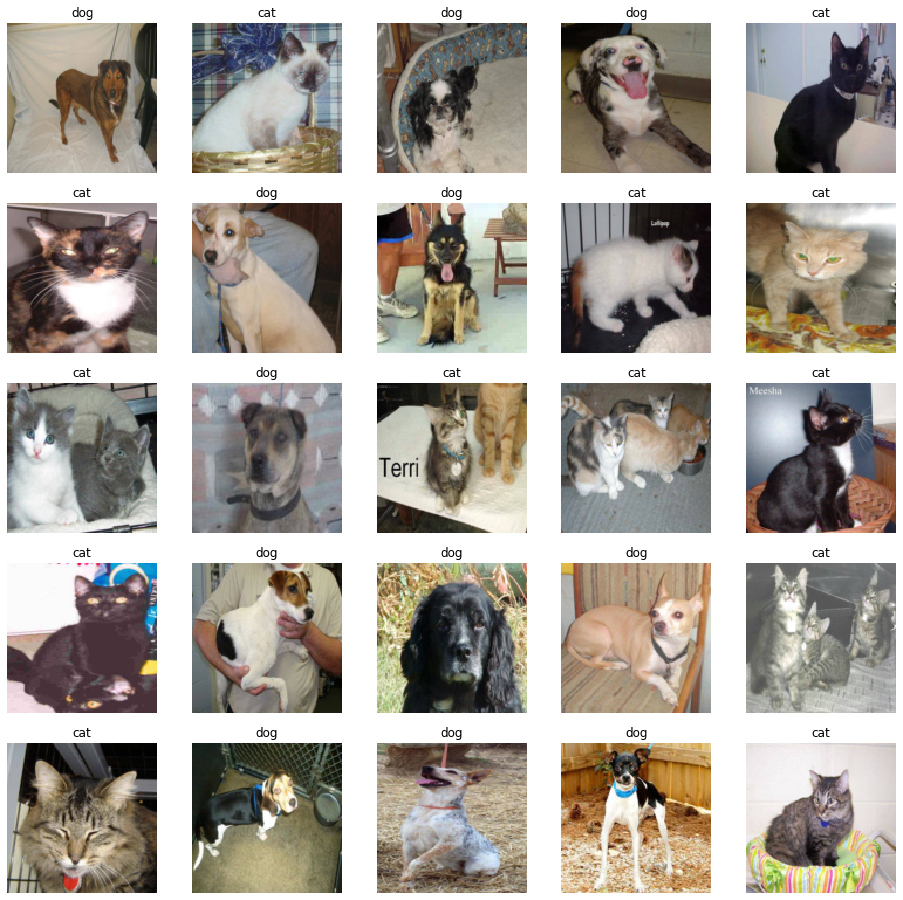

In [20]:
fig = figure(0, (16, 16))
for i in range(25):
    fig.add_subplot(5,5,i+1)
    imshow(np.moveaxis(x[i, :, :, :].numpy(), (0, 1, 2), (2,0,1))); axis('off')
    title(labels[y.numpy()[i]])

In [21]:
#Here's an example model that uses some of these 
model = nn.Sequential(nn.Conv2d(3, 64, kernel_size=5, stride=2), nn.ReLU(), nn.BatchNorm2d(64),
                      nn.Conv2d(64, 128, kernel_size=3,stride=2), nn.ReLU(), nn.BatchNorm2d(128),
                      nn.Conv2d(128, 256, kernel_size=3,stride=2), nn.ReLU(), nn.BatchNorm2d(256),  
                      nn.AdaptiveAvgPool2d(output_size=(4,4)),
                      Lambda(lambda x: x.view(x.size(0),-1)), 
                      nn.Dropout(0.5), 
                      nn.Linear(16*256, 120), nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(120, 2)).to(device)

In [22]:
num_epochs = 10; lr = 1e-3; accuracies_cross_entropy = [] #We can use a higher learning rate with cross entroy loss. 

opt = optim.Adam(model.parameters(), lr=lr)
for i in range(num_epochs):
    for x, y in train_dl:
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        loss = F.cross_entropy(yhat, y) #Takes care of softmax and one hot encoding for us!
        loss.backward() 
        opt.step(); opt.zero_grad();
    
    #Check validation loss and accuracy at the end of each epoch:
    model.eval() #Put in evaluation mode!
    with torch.no_grad():
        x, y = next(iter(valid_dl)) #Just measure on one minibatch
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        max_values, max_indices = torch.max(yhat, dim=1)
        accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
        accuracies_cross_entropy.append(accuracy)
        print('Epoch: ' + str(i+1) + ', training loss = ' + str(round(loss.item(), 3)) + \
              ', valid accuracy = ' + str(round(accuracy, 3)))

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/connection.py", lin

KeyboardInterrupt: 

## 5. [Interactive] Cats vs Dogs with Pretrained Model

As we discussed, one really exciting thing about deep learning is how well pretrained models are able to generalize to new tasks. This idea is called transfer learning. Let's give this a shot here, by using a pretrained AlexNet model on the Cats vs Dogs problem!

In [26]:
import torchvision.models as models

In [27]:
alexnet = models.alexnet(pretrained=True)

In [39]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Freeze the layers we don't want to train:

In [42]:
for param in alexnet.features.parameters():
    param.requires_grad = False
    
for param in alexnet.classifier[:5].parameters():
    param.requires_grad = False  

We have a different number of output classes than the original alexnet model:

In [43]:
alexnet.classifier[6]=nn.Linear(4096, 2)

In [45]:
model=model.to(device)

In [46]:
num_epochs = 10; lr = 1e-3; accuracies_cross_entropy = [] #We can use a higher learning rate with cross entroy loss. 

opt = optim.Adam(model.parameters(), lr=lr)
for i in range(num_epochs):
    for x, y in train_dl:
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        loss = F.cross_entropy(yhat, y) #Takes care of softmax and one hot encoding for us!
        loss.backward() 
        opt.step(); opt.zero_grad();
    
    #Check validation loss and accuracy at the end of each epoch:
    model.eval() #Put in evaluation mode!
    with torch.no_grad():
        x, y = next(iter(valid_dl)) #Just measure on one minibatch
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        max_values, max_indices = torch.max(yhat, dim=1)
        accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
        accuracies_cross_entropy.append(accuracy)
        print('Epoch: ' + str(i+1) + ', training loss = ' + str(round(loss.item(), 3)) + \
              ', valid accuracy = ' + str(round(accuracy, 3)))

Traceback (most recent call last):
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/stephenwelch/anaconda3/envs/dl-workshop/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send

KeyboardInterrupt: 

In our next session, we'll speed all of this up dramatically with fastai!